#**주차 수요 예측**
# 단계1 : 데이터 전처리

## 0.미션

단지별 등록 차량 수를 예측하고자 함 -> 데이터 전처리 필요.
* 1) 단지별 데이터와 상세 데이터를 분리.
* 2) 단지별 데이터
    * 범주의 수 줄이기 : 너무 종류가 많은 범주는 의미상 적절하게 병합.
* 3) 상세 데이터를 단지별로 집계.
    * 전용면적 : 구간으로 나누어 집계하기
    * 임대보증금 혹은 임대료 : 전용면적별 세대수를 감안하여 집계하기.
* 4) 단지별 데이터와 집계데이터를 하나로 합침.
* 5) (옵션)추가 변수 만들기
    * 등록 차량수를 예측하기 위해 필요한 변수를 추가.

## 1.환경설정

### (1) 한글폰트 설치

In [575]:
# # 한글폰트
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

* (구글콜랩) 한글폰트 설치후 런타임 재시작!

### (2) 경로 설정

#### 1) 로컬 수행(Anaconda)

In [576]:
# path = '../데이터/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [577]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path = 'C:/Users/User/Desktop/에이블스쿨/미프/미프3차/3차_2/데이터/'

### (3) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드 실행.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [579]:
# !pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요한 라이브러리 로딩

In [10]:
# import matplotlib.font_manager as fm
# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list.sort()
# font_list

In [11]:
# 한글폰트설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### (4) 데이터 불러오기

* 주어진 데이터셋
    * train.xlsx : 학습 및 검증용
    * test.xlsx : 테스트용

#### 1) 데이터로딩

In [36]:
data = pd.read_excel(path+'train.xlsx')

In [37]:
data_test = pd.read_excel(path+'test.xlsx')

#### 2) 기본 정보 조회

In [38]:
#전체 데이터의 행,열 개수 확인
data.shape

(1157, 15)

In [39]:
#전체 데이터의 상위 5개 행 확인
data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023.0,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88


In [40]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.103000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,1.973918e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,2.392214e+06,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,2.002000e+03,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.004052e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.009102e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


In [41]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['단지코드', '단지명', '총세대수', '전용면적별세대수', '지역', '준공일자', '건물형태', '난방방식',
       '승강기설치여부', '단지내주차면수', '전용면적', '공급면적(공용)', '임대보증금', '임대료', '실차량수'],
      dtype='object')

## 2.데이터 전처리①

* **세부 처리사항**
    * NaN 조치
        * NaN은 조회
        * 준공일자만 여기서 조치.
            * 준공연도만 필요. 문자열로 변환한 후 앞 4자리를 잘라 준공연도로 변환.
            * 잘못 들어간 데이터들과 nan 문자를 준공연도 최소값으로 치환.
        * 나머지 변수들은 탐색 이후에 조치를 취함함.
    * 불필요한 데이터 제거


### (1) NaN 조치

In [42]:
# 결측치 확인
data.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자        54
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공급면적(공용)     0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

In [43]:
# 준공일자 -> str, 연도만 추출
data['준공일자'] = data['준공일자'].astype(str).str[:4]  # 연도만 추출하여 문자열로 변환
data['준공일자'] = data['준공일자'].apply(lambda x: np.nan if x == 'nan' or int(x) < 1970 else int(x))  # 1970보다 작으면 결측치로 처리
data['준공일자'].fillna(data['준공일자'].min(), inplace=True)  # 결측치를 최솟값으로 대체
data['준공일자'] = data['준공일자'].astype(int)
data['준공일자'] = data['준공일자'].astype(str)

In [44]:
# 결측치 확인
print(data.isna().sum())
data.head(2)

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공급면적(공용)     0
임대보증금        0
임대료          0
실차량수         0
dtype: int64


,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,2013,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,2013,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109


### (2) 불필요한 칼럼 제거

* **세부 처리사항**
    * 단지명 : 분석단위로 볼때 단일값.
    * 단지내주차면수 :
        * 본 문제는 등록차량수를 예측하고, 그것을 기반으로 주차면수를 정하는 것이 목적.
        * 그런데, 역으로 주차면수 먼저 정한후 그것을 기반으로 등록차량수를 예측하는 것은 성립될 수 없음.

* 불필요한 정보 제거하기

In [45]:
data = data.drop(columns=['단지명','단지내주차면수'], axis=1)

In [46]:
data.head()

,단지코드,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,전용면적,공급면적(공용),임대보증금,임대료,실차량수
0,C0001,78,35,서울,2013,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109
1,C0001,78,43,서울,2013,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109
2,C0002,35,26,서울,2013,복도식,개별가스난방,전체동 설치,27.75,16.5375,63062000,458640,35
3,C0002,35,9,서울,2013,복도식,개별가스난방,전체동 설치,29.08,17.3302,63062000,481560,35
4,C0003,88,7,서울,2013,계단식,개별가스난방,전체동 설치,59.47,21.9462,72190000,586540,88


## 3.데이터 전처리②

* **세부 처리사항**

    * 1) 데이터프레임을 두가지 형태로 나눔.

    * 2) 상세 데이터 집계하기

    * 3) 단지별 데이터와 상세 데이터 집계 결과 merge 시키기



### (1) 데이터프레임 두개로 나누기

* **세부 처리사항**
    * 단지별 데이터
        * 단지코드, 총세대수, 지역, 준공일자, 건물형태, 난방방식, 승강기설치여부, 실차량수
        * 단지별 데이터를 분할 한 후, 중복행을 제거.
        * 중복행이 잘 제거 되었는지 확인.
    * 상세 데이터
        * 단지코드, 전용면적별세대수,전용면적, 공급면적(공용),임대보증금,임대료

In [47]:
# 단지별 데이터
data1 = data.copy()
data1 = data1[['단지코드', '총세대수', '지역', '준공일자', '건물형태', '난방방식', '승강기설치여부', '실차량수']]
data1.drop_duplicates(inplace=True)
display(data1.tail(2))
data1.shape

,단지코드,총세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,실차량수
1153,C0358,120,강원,2020,복도식,NaN,전체동 설치,47
1155,C0359,447,대구경북,1994,복도식,중앙유류난방,전체동 설치,78


(345, 8)

In [48]:
# 상세 데이터
data2 = data.copy()
data2 = data2[['단지코드', '전용면적별세대수','전용면적', '공급면적(공용)','임대보증금','임대료']]
display(data2.tail(2))
data2.shape

,단지코드,전용면적별세대수,전용면적,공급면적(공용),임대보증금,임대료
1155,C0359,149,26.37,13.38,7134000,118880
1156,C0359,298,31.32,13.85,8122000,131140


(1157, 6)

### (2) 상세 데이터 집계하기

* **세부 처리사항**
    * 전용면적 구간으로 나누기
        * 전용면적을 의미 있는 단위로 자른 칼럼 만들기 (pd.cut)
        * 구간별 세대 수 집계
        * pivot
    * 임대보증금 혹은 임대료 : 적절하게 집계하기.
        * 평균, 가중평균, 중앙값 중에서 고려하기.
    * 임대건물구분, 공급유형
        * 전체 면적을 계산합니다.(공급면적 * 세대수)
        * 임대건물구분 별, 면적 합계를 구한 후, 면적 비율을 계산.
        * 역시, 공급 유형별, 면적 합계를 구한 후, 면적 비율을 계산.

#### 1) 전용면적

In [49]:
# 전용면적 구간별 세대수
bins = [10,30,40,50,60,70,80,np.inf]
label = ['전용면적_10_30', '전용면적_30_40', '전용면적_40_50', '전용면적_50_60', '전용면적_60_70', '전용면적_70_80','전용면적_80_max',]
df1 = data2[['단지코드', '전용면적', '전용면적별세대수']]
df1['전용면적구간'] = pd.cut(df1['전용면적'], bins=bins, labels=label)
df1

C:\Users\User\AppData\Local\Temp\ipykernel_2656\1864280772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['전용면적구간'] = pd.cut(df1['전용면적'], bins=bins, labels=label)


,단지코드,전용면적,전용면적별세대수,전용면적구간
0,C0001,51.89,35,전용면적_50_60
1,C0001,59.93,43,전용면적_50_60
2,C0002,27.75,26,전용면적_10_30
3,C0002,29.08,9,전용면적_10_30
4,C0003,59.47,7,전용면적_50_60
...,...,...,...,...
1152,C0356,26.37,956,전용면적_10_30
1153,C0358,24.83,66,전용면적_10_30
1154,C0358,33.84,54,전용면적_30_40
1155,C0359,26.37,149,전용면적_10_30


In [50]:
df1 = df1.pivot_table(index='단지코드', columns='전용면적구간', values='전용면적별세대수', aggfunc='sum')
df1 = df1.rename_axis(None, axis=1)
df1.reset_index(inplace=True)
df1

,단지코드,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max
0,C0001,0,0,0,78,0,0,0
1,C0002,35,0,0,0,0,0,0
2,C0003,0,0,0,88,0,0,0
3,C0004,0,0,0,150,0,216,111
4,C0006,15,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
340,C1341,140,0,0,0,0,0,0
341,C1354,1071,298,0,17,0,0,0
342,C2307,196,0,0,0,0,0,0
343,C2343,80,0,0,0,0,0,0


#### 2) 임대보증금, 임대료 집계 하기(평균)

In [51]:
# 단지별 임대보증금
df2_1 = data2.groupby(by='단지코드', as_index=False)['임대보증금'].mean()
df2_1

,단지코드,임대보증금
0,C0001,5.696200e+07
1,C0002,6.306200e+07
2,C0003,7.219000e+07
3,C0004,1.015167e+08
4,C0006,5.522750e+07
...,...,...
340,C1341,1.188600e+07
341,C1354,8.092875e+06
342,C2307,1.180250e+07
343,C2343,1.211700e+07


In [52]:
# 단지별 임대료 평균
df2_2 = data2.groupby(by='단지코드', as_index=False)['임대료'].mean()
df2_2

,단지코드,임대료
0,C0001,642930.000000
1,C0002,470100.000000
2,C0003,586540.000000
3,C0004,950305.000000
4,C0006,340148.333333
...,...,...
340,C1341,93000.000000
341,C1354,111848.750000
342,C2307,94055.000000
343,C2343,108000.000000


#### 3) 단지별 총 면적 구하기

In [53]:
data2['총면적'] = data['전용면적']*data['전용면적별세대수']
df3 = data2.copy()

df3 = df3.groupby(by='단지코드', as_index=False)['총면적'].sum()

### (3) 합치기

* **세부 처리사항**
    * [단지별 데이터]를 기준으로 상세데이터로 만든 데이터셋을 하나씩 merge
    * merge를 사용할 때, **how = 'left', on = '단지코드'** 옵션을 이용.
        * [단지별 데이터]가 기준(left).

* 단지별 데이터 + 전용면적별 세대수

In [54]:
result1 = pd.merge(data1, df1, how='left', on='단지코드')
result1 = pd.merge(result1, df3, how='left', on='단지코드')
result1

,단지코드,총세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,4393.14
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,983.22
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,5244.69
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,0,216,111,34607.34
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,309.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298,1181,298,0,6,0,0,0,40792.77
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258,1071,298,0,17,0,0,0,38472.21
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243,956,0,0,0,0,0,0,25209.72
343,C0358,120,강원,2020,복도식,NaN,전체동 설치,47,66,54,0,0,0,0,0,3466.14


* 평균 임대 보증금/임대료 합치기

In [55]:
result2 = pd.merge(df2_1, df2_2, how='left', on='단지코드')
base_data = pd.merge(result1, result2, how='left', on='단지코드')

## 4.데이터셋 저장하기

* **세부 처리사항**
    * joblib.dump를 이용.

In [56]:
joblib.dump(base_data, path + 'base_data.pkl')

['C:/Users/User/Desktop/에이블스쿨/미프/미프3차/3차_2/데이터/base_data.pkl']

#**주차 수요 예측**
# 단계2 : 탐색적 데이터 분석

## 0.요약

* 단계1 에서 생성한 base_data에 대해서 탐색적 분석을 수행.
* 1) 단변량 분석
    * 숫자형, 범주형 변수에 맞게 데이터를 탐색하며 비즈니스를 파악.
* 2) 이변량 분석
    * Target은 실차량수(숫자)
    * 숫자형 feature --> 숫자형 Target 에 대해 전체 상관계수를 구해 확인.
        * 상관계수가 높은 feature들에 대해 따로 산점도를 그려 확인.
    * 범주형 feature --> 숫자형 Target
        * 평균 비교 barplot(sns.barplot)을 활용하여 비교.
* 3) 전처리 추가
    * 범주형 feature 중에는 적은 수의 범주가 포함되어 있음. 가능한 범주끼리 묶어 봄.

## 1.환경설정

### (3) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드를 실행.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [33]:
# !pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib



In [82]:
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

### (4) 데이터 불러오기

* **세부 요구사항**
    - 전처리 단계에서 저장한 파일을 불러옴

In [83]:
data = joblib.load(path+'base_data.pkl')

In [84]:
data.head()

,단지코드,총세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,4393.14,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,983.22,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,5244.69,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,0,216,111,34607.34,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,309.50,5.522750e+07,340148.333333


## 2.탐색적 데이터분석

* **세부 처리사항**
    * 기본 분석
        * 기초 통계량, NaN 값 확인 등 기본 분석을 수행.
    * 단변량 분석
        - 단일 변수로 분석 : 등록차량수, 총세대수, 버스정류장수, 지하철역수, 공가수, 임대료, 보증금
        - 여러 변수를 묶어서 분석 : 건물구분, 공급유형
    * 이변량 분석
        - 전체 상관계수를 구하고 시각화.
        - 상관계수가 높은 변수에 대한 산점도를 구함

### (1) 기본 분석

* **세부 처리사항**
    - 데이터프레임 전체에 대한 기초통계량을 구함.
    - NaN을 확인.

In [85]:
display(data.head(5))
display(data.describe())
print(data.shape)
print(data.columns)

,단지코드,총세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,4393.14,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,983.22,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,5244.69,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,0,216,111,34607.34,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,309.50,5.522750e+07,340148.333333


,총세대수,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적,임대보증금,임대료
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,3.450000e+02,345.000000
mean,546.759420,555.431884,45.837681,169.513043,147.455072,132.889855,1.852174,16.895652,34.515942,26324.872091,2.382737e+07,197729.050210
std,432.359538,374.640474,161.133746,222.935074,216.675593,252.947082,32.771294,76.441995,116.975949,20983.244126,2.247481e+07,158760.777669
min,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.690000,0.000000e+00,0.000000
25%,178.000000,258.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8483.260000,1.272491e+07,112905.000000
50%,491.000000,498.000000,0.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23018.230000,1.930850e+07,172000.000000
75%,853.000000,822.000000,0.000000,298.000000,264.000000,150.000000,0.000000,0.000000,0.000000,38910.140000,2.837700e+07,227564.000000
max,2289.000000,1657.000000,1181.000000,1429.000000,1258.000000,1444.000000,608.000000,756.000000,850.000000,112889.440000,1.898219e+08,950305.000000


(345, 18)
Index(['단지코드', '총세대수', '지역', '준공일자', '건물형태', '난방방식', '승강기설치여부', '실차량수',
       '전용면적_10_30', '전용면적_30_40', '전용면적_40_50', '전용면적_50_60', '전용면적_60_70',
       '전용면적_70_80', '전용면적_80_max', '총면적', '임대보증금', '임대료'],
      dtype='object')


In [86]:
data.isna().sum()

단지코드            0
총세대수            0
지역              0
준공일자            0
건물형태            6
난방방식           26
승강기설치여부        23
실차량수            0
전용면적_10_30      0
전용면적_30_40      0
전용면적_40_50      0
전용면적_50_60      0
전용면적_60_70      0
전용면적_70_80      0
전용면적_80_max     0
총면적             0
임대보증금           0
임대료             0
dtype: int64

### (2) 단변량 분석



* **세부 처리사항**
    - 주요 변수들의 분포를 살펴보며 비즈니스를 파악.
    - 단일 변수로 분석
        * 대상 : 등록차량수, 총세대수, 버스정류장수, 지하철역수, 공가수, 임대료, 보증금
        * 도구 : 기초통계량, boxplot, histogram 을 통한 데이터 분포 파악
    - 여러 변수를 묶어서 분석 : 전용면적, 건물구분, 공급유형
        * pd.melt를 이용하여 pivot을 해제하고
        * sns.barplot으로 그래프를 그려서 비교해 봄.

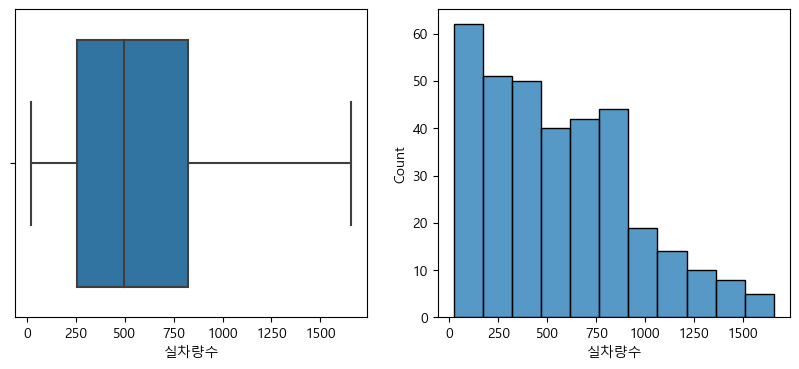

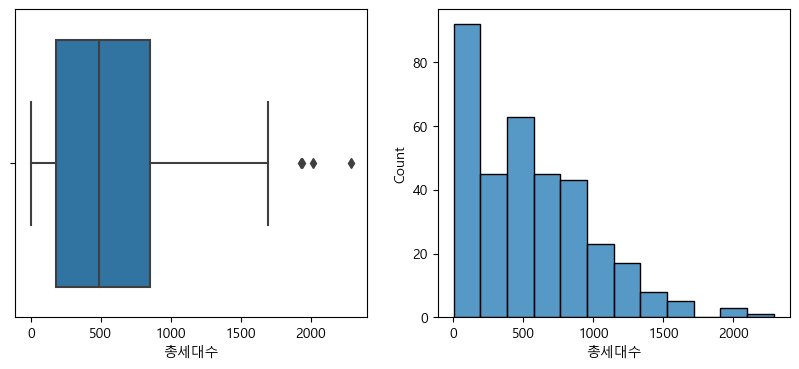

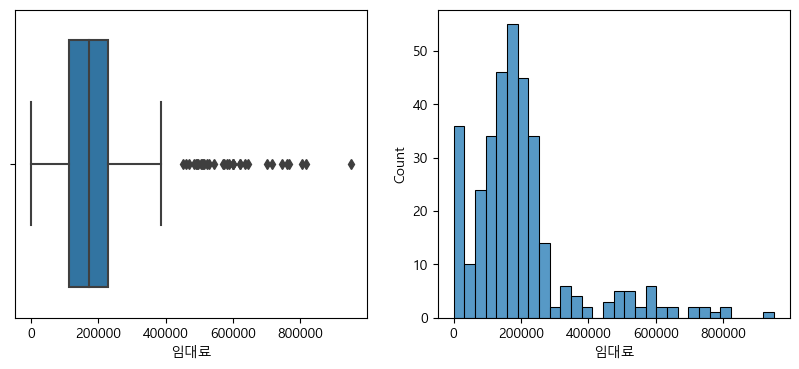

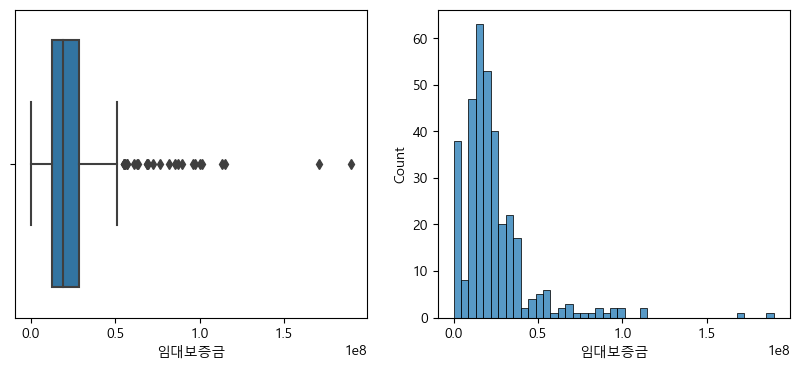

In [87]:
targets = ['실차량수', '총세대수', '임대료', '임대보증금']
for target in targets:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(data=data, x=target)

    plt.subplot(1,2,2)
    sns.histplot(data=data, x=target)
    plt.show()

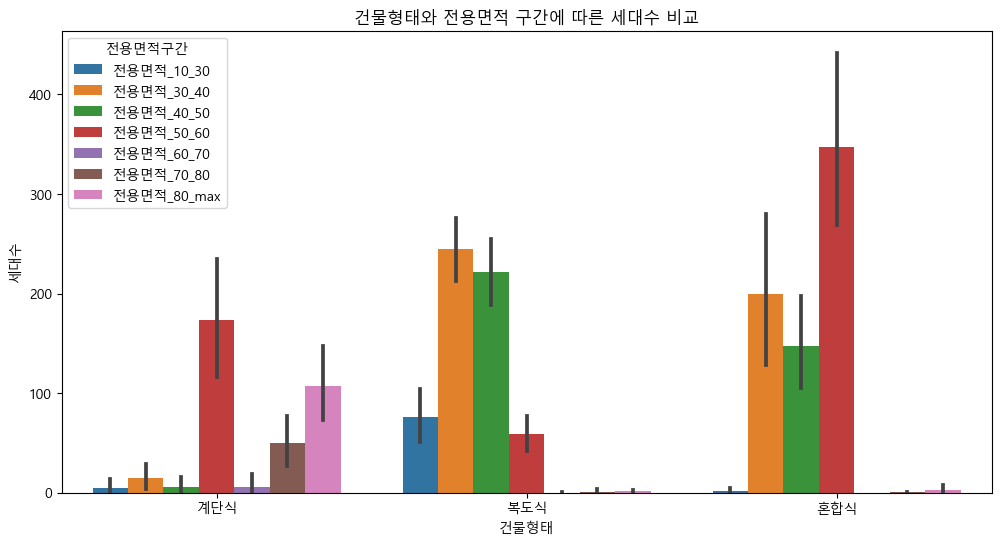

In [88]:
col = ['건물형태', '전용면적_10_30', '전용면적_30_40', '전용면적_40_50', '전용면적_50_60', '전용면적_60_70', '전용면적_70_80', '전용면적_80_max']
df = data[col]

# pd.melt를 사용하여 pivot을 해제합니다.
df = pd.melt(df, id_vars=['건물형태'], value_vars=col[1:], var_name='전용면적구간', value_name='세대수')

# seaborn의 barplot으로 그래프를 그립니다.
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='건물형태', y='세대수', hue='전용면적구간')
plt.title('건물형태와 전용면적 구간에 따른 세대수 비교')
plt.xlabel('건물형태')
plt.ylabel('세대수')
plt.legend(title='전용면적구간')
plt.show()

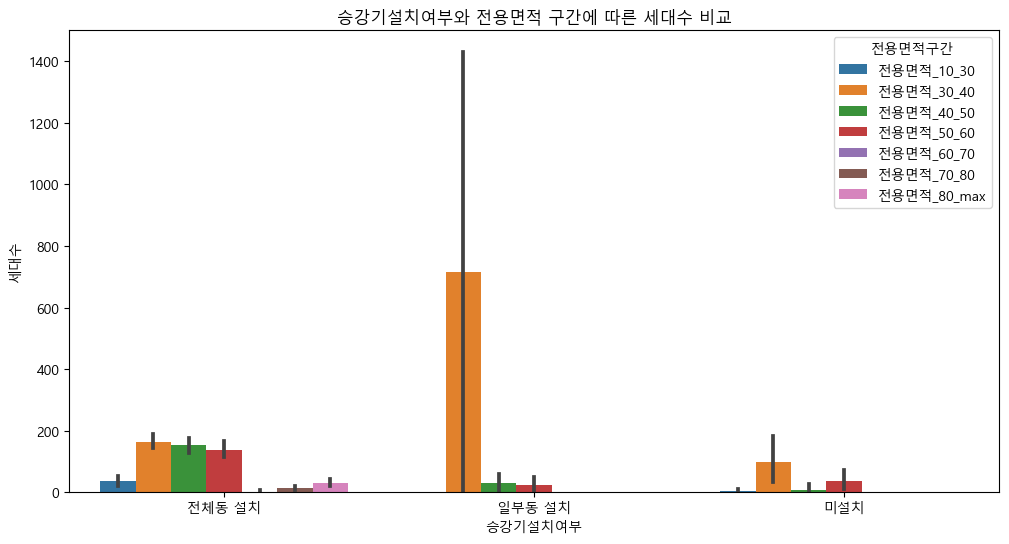

In [89]:
col = ['승강기설치여부', '전용면적_10_30', '전용면적_30_40', '전용면적_40_50', '전용면적_50_60', '전용면적_60_70', '전용면적_70_80', '전용면적_80_max']
df = data[col]

# pd.melt를 사용하여 pivot을 해제합니다.
df = pd.melt(df, id_vars=['승강기설치여부'], value_vars=col[1:], var_name='전용면적구간', value_name='세대수')

# seaborn의 barplot으로 그래프를 그립니다.
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='승강기설치여부', y='세대수', hue='전용면적구간')
plt.title('승강기설치여부와 전용면적 구간에 따른 세대수 비교')
plt.xlabel('승강기설치여부')
plt.ylabel('세대수')
plt.legend(title='전용면적구간')
plt.show()

In [90]:
# 기초 통계량
data[targets].describe()

,실차량수,총세대수,임대료,임대보증금
count,345.000000,345.000000,345.000000,3.450000e+02
mean,555.431884,546.759420,197729.050210,2.382737e+07
std,374.640474,432.359538,158760.777669,2.247481e+07
min,21.000000,1.000000,0.000000,0.000000e+00
25%,258.000000,178.000000,112905.000000,1.272491e+07
50%,498.000000,491.000000,172000.000000,1.930850e+07
75%,822.000000,853.000000,227564.000000,2.837700e+07
max,1657.000000,2289.000000,950305.000000,1.898219e+08


### (3) 이변량 분석

* **세부 처리사항**
    - 숫자형 feature --> target
        - 전체 변수들 간의 상관관계 구하기
            * 범주형 변수를 제외한 데이터셋을 이용하여
            * df.corr() + sns.heatmap() 으로 전체 상관계수를 시각화.
        - 등록차량수와 상관계수가 높은 상위 3~5개에 대해서 산점도를 그려봄.
    - 범주형 feature --> target
        * 지역 : sns.barplot()으로 시각화.

#### 1) 전체 숫자형 변수들 간의 상관관계

In [91]:
corr=data.corr(numeric_only=True)

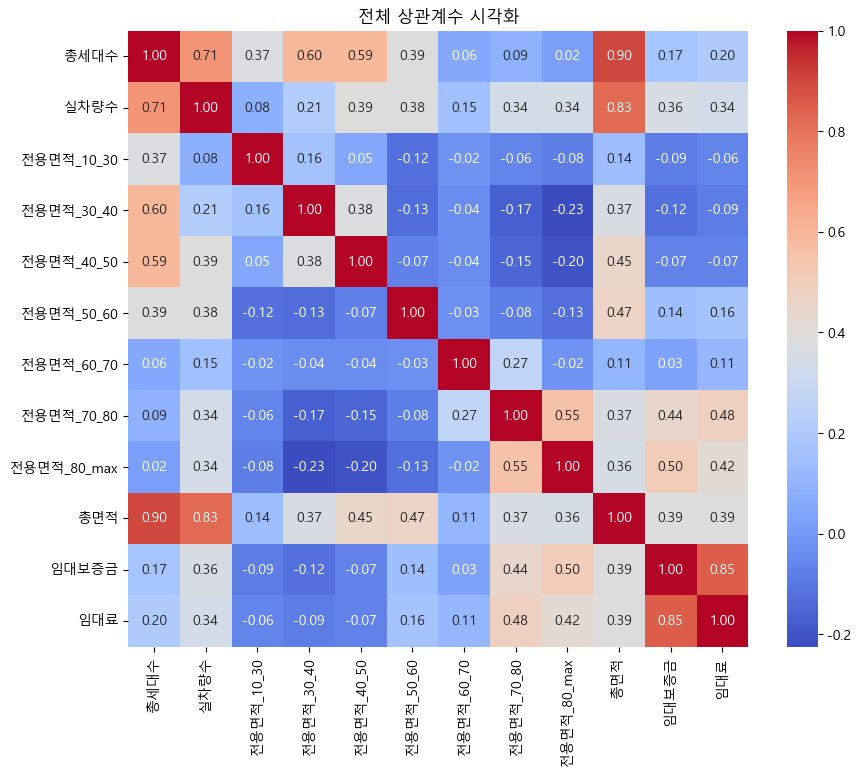

In [92]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('전체 상관계수 시각화')
plt.show()

#### 2) 숫자형 feature --> 실차량수

In [93]:
corr_num = corr[['실차량수']]
top5 = corr_num.sort_values('실차량수', ascending=False)[1:6]
top5.T

,총면적,총세대수,전용면적_40_50,전용면적_50_60,임대보증금
실차량수,0.825102,0.712475,0.392296,0.381746,0.361867


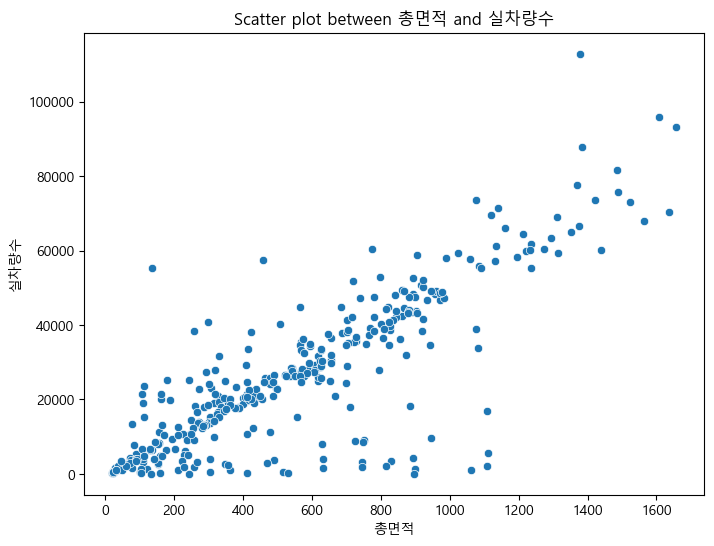

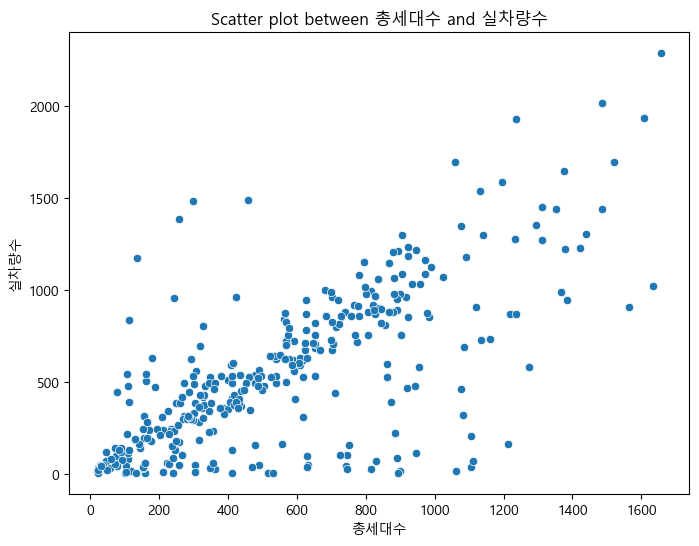

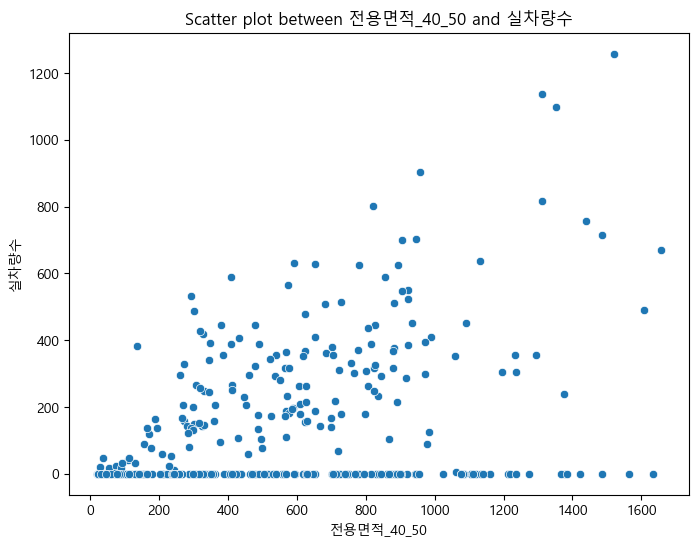

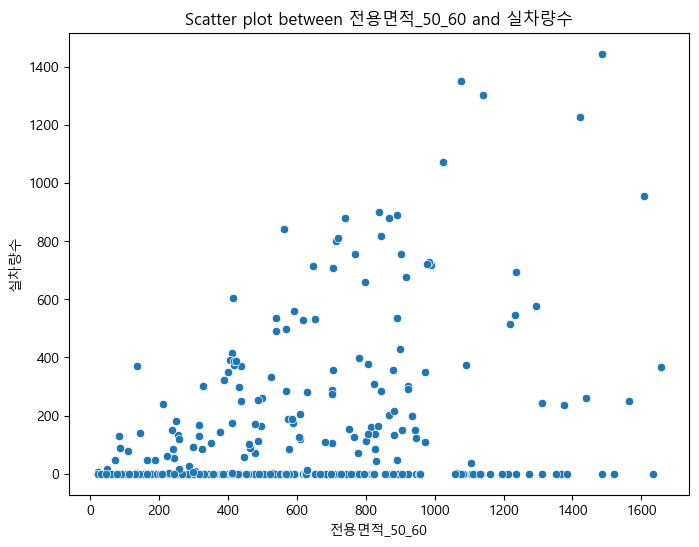

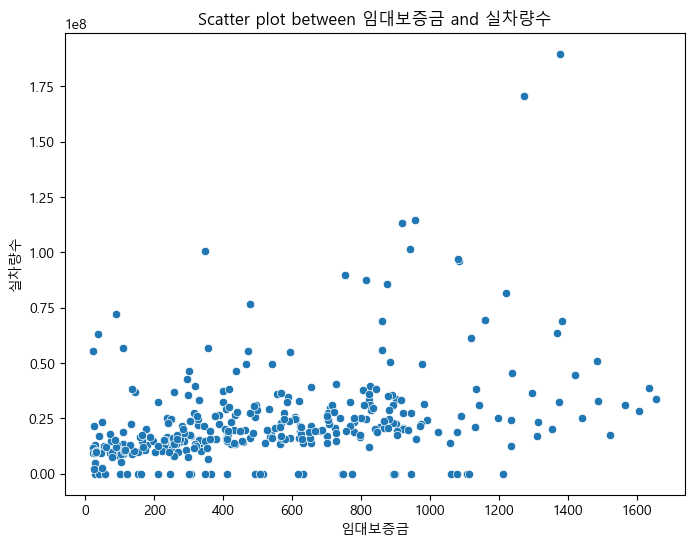

In [94]:
for feature in top5.T:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='실차량수', y=feature)
    plt.title(f'Scatter plot between {feature} and 실차량수')
    plt.xlabel(feature)
    plt.ylabel('실차량수')
    plt.show()

#### 3) 범주형 feature --> 실차량수

In [95]:
features = data.select_dtypes(include=['object']).drop('단지코드', axis=1).columns
features

Index(['지역', '준공일자', '건물형태', '난방방식', '승강기설치여부'], dtype='object')

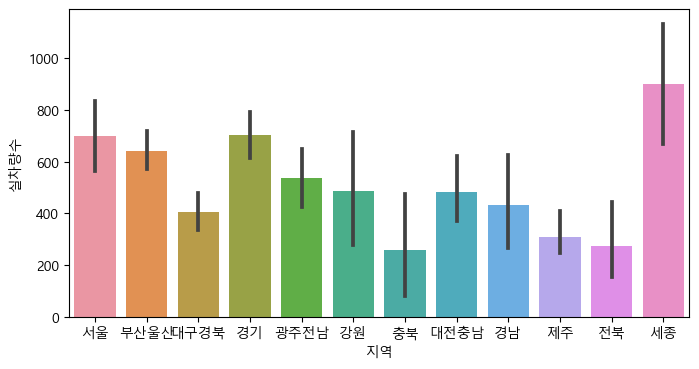

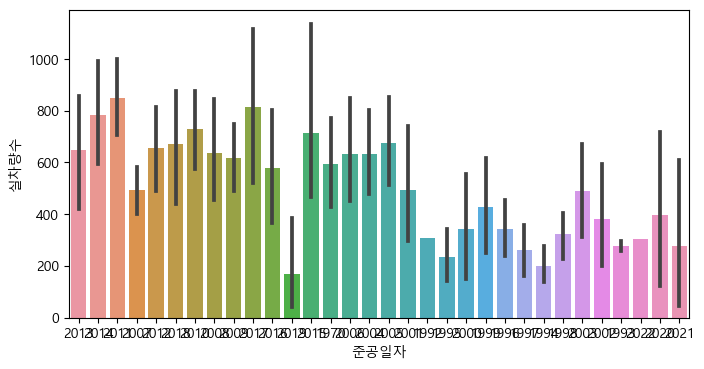

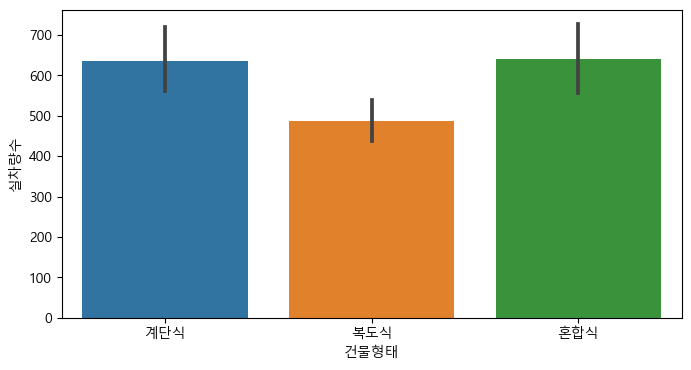

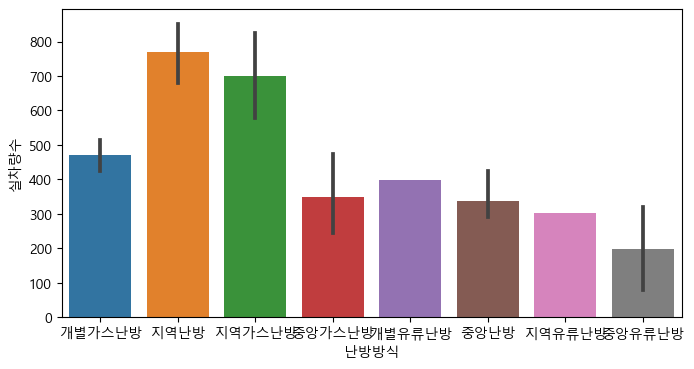

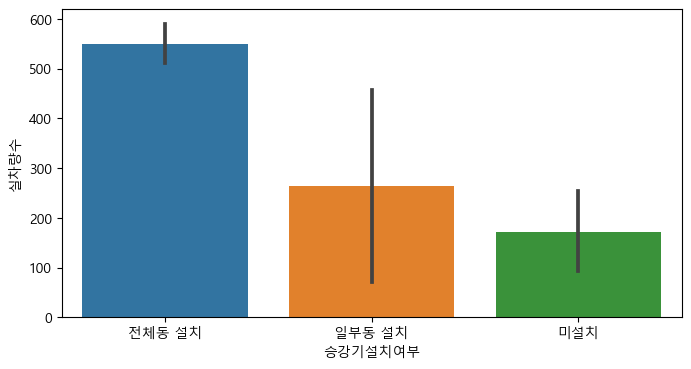

In [96]:
# 각 feature별 평균
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=data, x=feature, y='실차량수')
    plt.show()

## 3.전처리_추가

* **세부처리사항**
    * 난방방식, 승강기설치여부 두 변수에 대해서 적은 수의 범주를 묶는 작업을 시도.
    * 지역 : 지역별 특성을 고려하기에는 너무 세분화 되어 있고, 특징으로 통합하기 어려우므로 삭제.

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   단지코드         345 non-null    object 
 1   총세대수         345 non-null    int64  
 2   지역           345 non-null    object 
 3   준공일자         345 non-null    object 
 4   건물형태         339 non-null    object 
 5   난방방식         319 non-null    object 
 6   승강기설치여부      322 non-null    object 
 7   실차량수         345 non-null    int64  
 8   전용면적_10_30   345 non-null    int64  
 9   전용면적_30_40   345 non-null    int64  
 10  전용면적_40_50   345 non-null    int64  
 11  전용면적_50_60   345 non-null    int64  
 12  전용면적_60_70   345 non-null    int64  
 13  전용면적_70_80   345 non-null    int64  
 14  전용면적_80_max  345 non-null    int64  
 15  총면적          345 non-null    float64
 16  임대보증금        345 non-null    float64
 17  임대료          345 non-null    float64
dtypes: float64(3), int64(9), object(6)
memory usage: 4

In [98]:
data['난방방식'].value_counts()

난방방식
개별가스난방    184
지역난방       84
지역가스난방     30
중앙가스난방     14
중앙난방        3
중앙유류난방      2
개별유류난방      1
지역유류난방      1
Name: count, dtype: int64

In [99]:
# 난방방식 -> 개별, 지역, 중앙
data['난방방식'] = data['난방방식'].replace({'개별가스난방': '개별', '지역난방': '지역', '중앙가스난방': '중앙',
                                     '중앙난방': '중앙', '중앙유류난방': '중앙', '지역가스난방' : '지역',
                                     '지역유류난방': '지역', '개별유류난방': '개별'})


In [100]:
data['난방방식'].value_counts()

난방방식
개별    185
지역    115
중앙     19
Name: count, dtype: int64

In [101]:
data['승강기설치여부'].value_counts()

승강기설치여부
전체동 설치    310
미설치        10
일부동 설치      2
Name: count, dtype: int64

In [102]:
# 승강기설치여부 -> 설치 : 1, 미설치 : 0
data['승강기설치여부'] = data['승강기설치여부'].replace({'전체동 설치' : 1, '일부동 설치' : 1, '미설치' : 0})

# 결측치는 mod값(1)으로 처리
data['승강기설치여부'] = data['승강기설치여부'].fillna(1)

In [103]:
data['승강기설치여부'].value_counts()

승강기설치여부
1.0    335
0.0     10
Name: count, dtype: int64

In [104]:
# 지역 칼럼 제거
data.drop('지역', axis=1, inplace=True)

In [105]:
# # 결측치 채워넣기
# data.fillna(method='ffill', inplace=True)
# data.isna().sum()

## 4.데이터 저장

* **세부 처리사항**
    * joblib.dump를 이용

In [106]:
joblib.dump(data,path+'base_data2.pkl')

['C:/Users/User/Desktop/에이블스쿨/미프/미프3차/3차_2/데이터/base_data2.pkl']

In [107]:
joblib.load(path+'base_data2.pkl').head(5)

,단지코드,총세대수,준공일자,건물형태,난방방식,승강기설치여부,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적,임대보증금,임대료
0,C0001,78,2013,계단식,개별,1.0,109,0,0,0,78,0,0,0,4393.14,5.696200e+07,642930.000000
1,C0002,35,2013,복도식,개별,1.0,35,35,0,0,0,0,0,0,983.22,6.306200e+07,470100.000000
2,C0003,88,2013,계단식,개별,1.0,88,0,0,0,88,0,0,0,5244.69,7.219000e+07,586540.000000
3,C0004,477,2014,복도식,지역,1.0,943,0,0,0,150,0,216,111,34607.34,1.015167e+08,950305.000000
4,C0006,15,2013,복도식,개별,1.0,21,15,0,0,0,0,0,0,309.50,5.522750e+07,340148.333333


#### 3) 함수 생성

* 모델 실제 vs 예측결과 비교 그래프

In [108]:
def model_plot(y, pred) :
    plt.figure(figsize = (12,8))
    plt.scatter(y, pred, alpha=0.4)

    x_l = np.linspace( y.min(), y.max(), 100)
    plt.plot(x_l, x_l, color = 'black', alpha=0.4)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* **세부 처리사항**
    - 탐색적 데이터분석 단계에서 저장한 파일을 불러옴옴.

In [109]:
data = joblib.load(path+'base_data2.pkl')


In [110]:
data.head()

,단지코드,총세대수,준공일자,건물형태,난방방식,승강기설치여부,실차량수,전용면적_10_30,전용면적_30_40,전용면적_40_50,전용면적_50_60,전용면적_60_70,전용면적_70_80,전용면적_80_max,총면적,임대보증금,임대료
0,C0001,78,2013,계단식,개별,1.0,109,0,0,0,78,0,0,0,4393.14,5.696200e+07,642930.000000
1,C0002,35,2013,복도식,개별,1.0,35,35,0,0,0,0,0,0,983.22,6.306200e+07,470100.000000
2,C0003,88,2013,계단식,개별,1.0,88,0,0,0,88,0,0,0,5244.69,7.219000e+07,586540.000000
3,C0004,477,2014,복도식,지역,1.0,943,0,0,0,150,0,216,111,34607.34,1.015167e+08,950305.000000
4,C0006,15,2013,복도식,개별,1.0,21,15,0,0,0,0,0,0,309.50,5.522750e+07,340148.333333


## 2.모델링

* **세부 처리사항**
    * 모델링을 위한 전처리 : NaN 조치. 데이터 분할, 스케일링, 가변수화 등
    * 4개 이상의 알고리즘을 이용하여 모델 생성
    * 각 모델에 대해 성능 튜닝 수행
        * 선형회귀 : 릿지, 라쏘, 엘라스틱넷 중 1~2개 함께 사용하여 성능 비교
        * 랜덤포레스트 : 기본값으로 모델링 수행
        * 그외 알고리즘 : 그리드서치 튜닝으로 성능 최적화
    * 성능 비교를 통해 최적의 모델 선정
        * 검증 성능 가이드라인 : MAE : 120 내외

### (1) 데이터전처리


* **세부 처리사항**
    * 모델링을 위한 전처리를 수행.
        * x,y 분할(식별자 역할의 단지코드 칼럼 제거하고, x,y로 분할)
        * 단지코드 제거
        * 가변수화
        * 스케일링(필요시)
        * train : validation
            * 적절한 비율 사용하기
            * random_state 지정하기

In [111]:
# 임대료 이상치 제거
# row 36개 사라짐
data = data[data['임대료'] != 0]

#### 1) x, y 분할

In [112]:
target = '실차량수'
x = data.drop([target, '단지코드'], axis=1)
y = data[target]

#### 2) NaN 조치

In [113]:
x.isna().sum()

총세대수            0
준공일자            0
건물형태            6
난방방식           25
승강기설치여부         0
전용면적_10_30      0
전용면적_30_40      0
전용면적_40_50      0
전용면적_50_60      0
전용면적_60_70      0
전용면적_70_80      0
전용면적_80_max     0
총면적             0
임대보증금           0
임대료             0
dtype: int64

In [114]:
x['난방방식'].fillna(x['난방방식'].mode()[0], inplace=True)
x['승강기설치여부'].fillna(x['승강기설치여부'].mode()[0], inplace=True)
x['건물형태'].fillna(x['건물형태'].mode()[0], inplace=True)

#### 3) 가변수화

In [115]:
# 건물형태, 승강기설치여부, 난방방식
dummies = ['건물형태', '승강기설치여부', '난방방식']

x = pd.get_dummies(x, columns=dummies, drop_first=True)

#### 4) train : val 분할

In [116]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

#### 5) 스케일링

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### (2) 알고리즘 - 선형회귀 모델 3가지 (릿지, 라쏘, 엘라스틱넷)

In [118]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# alpha: 규제 강도를 조절하는 매개변수입니다. alpha가 크면 규제가 강해지고, 모델의 복잡성이 감소합니다.
# l1_ratio: L1 규제 (라쏘 규제)와 L2 규제 (릿지 규제)의 비율을 나타내는 매개변수


# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}  # 여러 가지 alpha 값 시도
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(x_train_s, y_train)  # x_train_s는 표준화 또는 정규화된 특성 데이터, y_train은 타겟 변수

# 최적의 Ridge 모델 및 파라미터
best_ridge = ridge_grid.best_estimator_
print("Best Ridge Model:", best_ridge)

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}  # 여러 가지 alpha 값 시도
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(x_train_s, y_train)

# 최적의 Lasso 모델 및 파라미터
best_lasso = lasso_grid.best_estimator_
print("Best Lasso Model:", best_lasso)

# ElasticNet Regression
elastic_net = ElasticNet()
elastic_net_params = {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}  # alpha와 l1_ratio 시도
elastic_net_grid = GridSearchCV(elastic_net, elastic_net_params, cv=5)
elastic_net_grid.fit(x_train_s, y_train)

# 최적의 ElasticNet 모델 및 파라미터
best_elastic_net = elastic_net_grid.best_estimator_
print("Best ElasticNet Model:", best_elastic_net)


Best Ridge Model: Ridge(alpha=1)
Best Lasso Model: Lasso(alpha=1)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.447e+03, tolerance: 2.564e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.454e+04, tolerance: 2.831e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.035e+04, tolerance: 

Best ElasticNet Model: ElasticNet(alpha=0.01)


### (3) 성능결과 비교

* 세부 처리사항
    - 각 모델에 대해서 test 데이터로 성능 측정후, 데이터프레임으로 저장하고 비교.

Ridge(alpha=1)
MAE: 116.06549807281017
R2: 0.8202179942826546


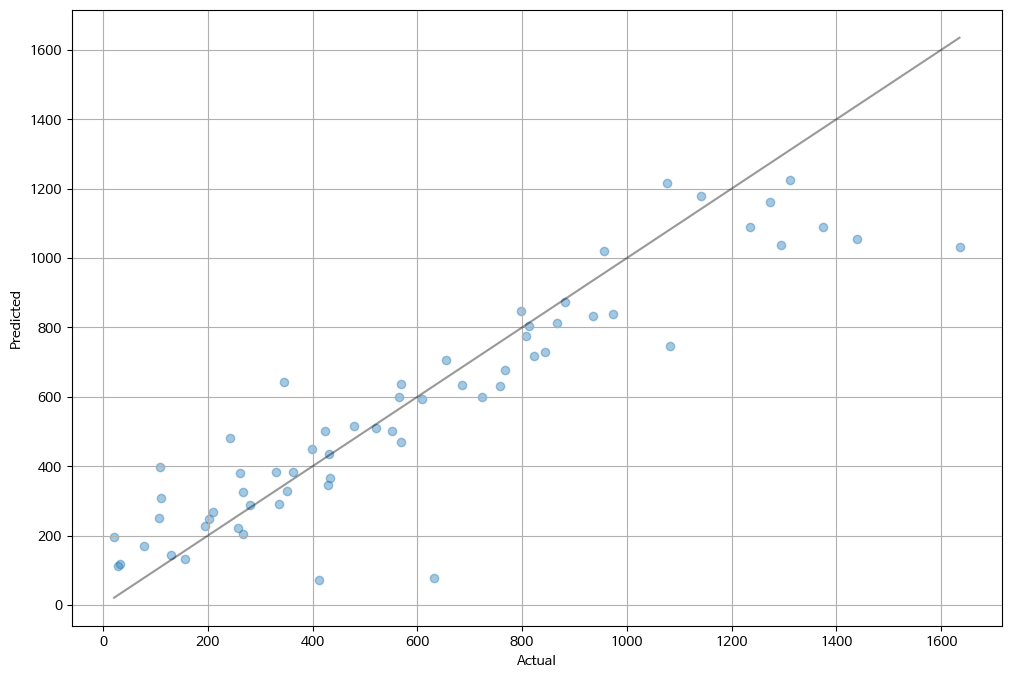

Lasso(alpha=1)
MAE: 109.28022599022013
R2: 0.8426674369637138


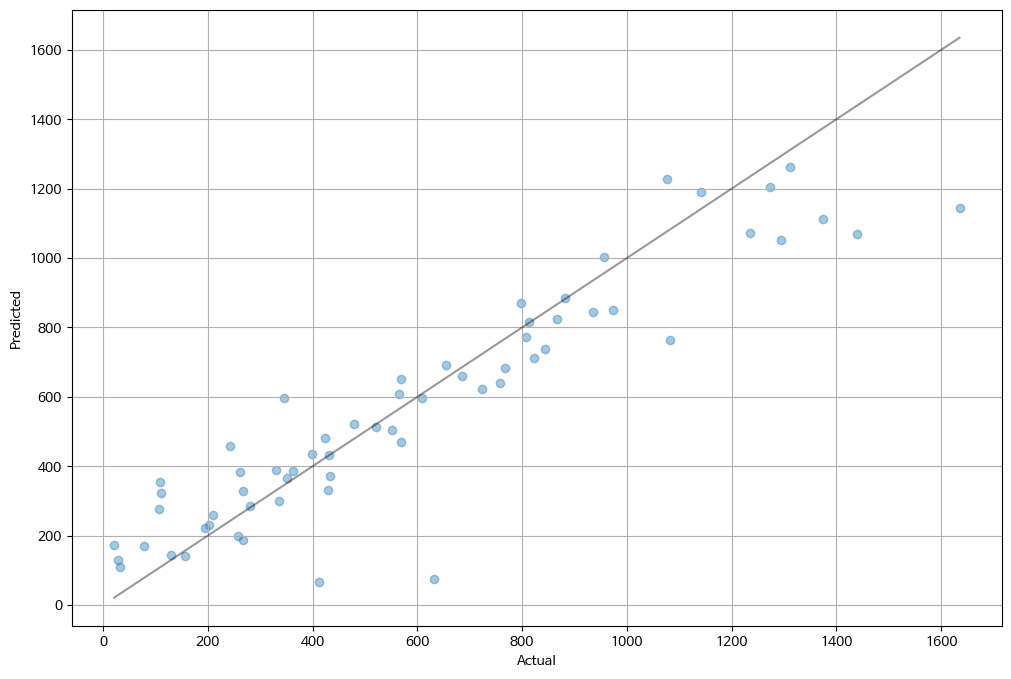

ElasticNet(alpha=0.01)
MAE: 116.77469832974884
R2: 0.8179217440332787


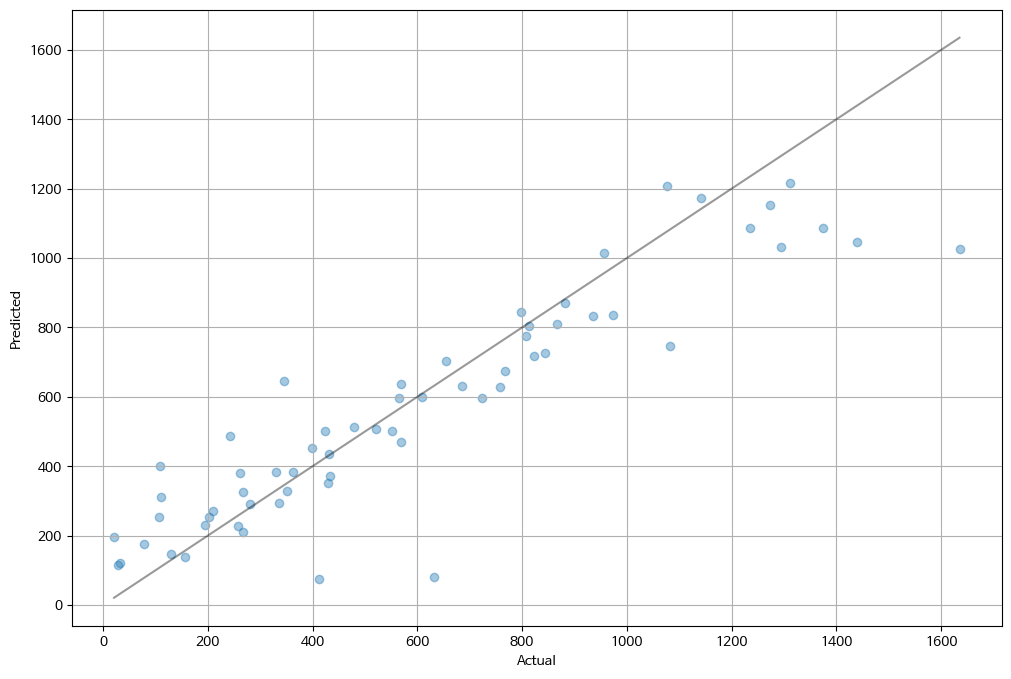

In [642]:
from sklearn.metrics import mean_absolute_error, r2_score

for model in [best_ridge, best_lasso, best_elastic_net]:
  pred = model.predict(x_val_s)
  print(model)
  print('MAE:', mean_absolute_error(y_val, pred))
  print('R2:', r2_score(y_val, pred))
  model_plot(y_val, pred)

## 3.파이프라인 구축

* **세부처리사항**
    * new data : data02_test.csv 를 읽어서 저장
    * 파이프라인 함수를 생성
        * data pipeline 함수
        * ML pipeline 함수

### (1) New Data 불러오기
* **세부처리사항**
    * test.xlsx 를 읽어서 new_data 이름으로 저장
    * 해당 데이터는 최초 데이터와 동일한 구조. 이 데이터를 이용하여 전처리와 예측을 수행해야 함.

In [643]:
new_data = pd.read_excel(path+'test.xlsx')

### (2) 데이터 파이프라인 구축
* **세부처리사항**
    * data pipeline 함수를 생성.
        * 입력 : new_data
        * 처리 :
            * 1.데이터전처리, 2.탐색적 데이터분석 단계에서 수행했던 전처리 코드들을 순차적으로 처리.
            * 모델링을 위한 전처리 : Target 제거, NaN조치, 가변수화, (스케일링) 등을 수행.
        * 출력 : 전처리 완료된 데이터 프레임
    

In [644]:
def data_pipeline(new_data):
  # 1.데이터전처리, 2.탐색적 데이터분석 단계에서 수행했던 전처리 코드들을 순차적으로 처리
  data0 = new_data.copy()

  data0['준공연도'] = data0['준공일자'].astype('str').str.slice(0, 4)
  data0.loc[data0['준공연도'].isin(['nan', '1900','1111']), '준공연도'] = '1992'
  data0['준공연도'] = data0['준공연도'].astype('int')

  vars = ['단지내주차면수', '단지명', '준공일자']
  data0.drop(vars, axis = 1, inplace = True)

  vars = ['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']
  data01 = data0[vars].copy()
  data01 = data01.drop_duplicates()
  data01.head()

  # 확인 : 단지 코드가 유니크해야 함.
  temp = data01.groupby('단지코드', as_index = False)['총세대수'].count()
  temp.columns = ['단지코드',	'count']
  temp.loc[temp['count']>1] # 위 칼럼으로 중복 행 없음.

  vars2 = ['단지코드', '전용면적별세대수','전용면적', '공급면적(공용)','임대보증금','임대료']
  data02 = data0[vars2].copy()
  data02.head()

  temp = data02.loc[: , ['단지코드','전용면적','전용면적별세대수']]
  temp['전용면적_cut'] = pd.cut(temp['전용면적'], bins = [10,30,40,50,60,70, 80, 200]
                            , labels = ['전용면적_10_30','전용면적_30_40','전용면적_40_50','전용면적_50_60','전용면적_60_70','전용면적_70_80', '전용면적_80_200'])
  temp2 = temp.groupby(['단지코드', '전용면적_cut'], as_index = False)['전용면적별세대수'].sum()
  temp3 = temp2.pivot(index='단지코드', columns='전용면적_cut', values='전용면적별세대수')
  temp3.reset_index(inplace = True)

  temp4 = data02.groupby('단지코드', as_index = False)[['임대보증금','임대료']].mean()
  temp4

  data02['총면적'] = data02['전용면적'] * data02['전용면적별세대수']
  temp6 = data02.groupby(['단지코드'], as_index = False)['총면적'].sum()

  base_data = pd.merge(data01,temp6, how = 'left', on = '단지코드')
  base_data = pd.merge(base_data,temp3, how = 'left', on = '단지코드')
  base_data = pd.merge(base_data,temp4, how = 'left', on = '단지코드')

  # 난방방식 : 중앙, 지역, 개별 세가지로 묶기
  base_data['난방방식'] = base_data['난방방식'].map({'개별가스난방':'개별', '지역난방':'지역', '지역가스난방':'지역',
                                            '중앙가스난방':'중앙', '개별유류난방':'개별', '중앙난방':'중앙',
                                            '지역유류난방':'지역', '중앙유류난방':'중앙'})

  # 난방방식 : 중앙, 지역, 개별 세가지로 묶기
  base_data['승강기설치여부'] = base_data['승강기설치여부'].map({'전체동 설치':1, '일부동 설치':0, '미설치':0})

  base_data.drop('지역', axis = 1, inplace = True)

  return base_data

In [645]:
def data_pipeline2(new_data):
  # 모델링을 위한 전처리 : Target 제거, NaN조치, 가변수화, (스케일링) 등을 수행

  target = '실차량수'
  x = data.drop([target, '단지코드'], axis=1)
  y = data[target]

  x['난방방식'].fillna(x['난방방식'].mode()[0], inplace=True)
  x['승강기설치여부'].fillna(x['승강기설치여부'].mode()[0], inplace=True)
  x['건물형태'].fillna(x['건물형태'].mode()[0], inplace=True)

  # 건물형태, 승강기설치여부, 난방방식
  dummies = ['건물형태', '승강기설치여부', '난방방식']

  x = pd.get_dummies(x, columns=dummies, drop_first=True)
  x = scaler.fit_transform(x)

  return x, y

In [646]:
row = data_pipeline(new_data)
x,y = data_pipeline2(row)

### (3) test
* **세부처리사항**
    * new_data로 부터, 전처리 및 예측 결과를 출력.

Ridge(alpha=1)
MAE: 108.2913295177248
R2: 0.8371165469784638


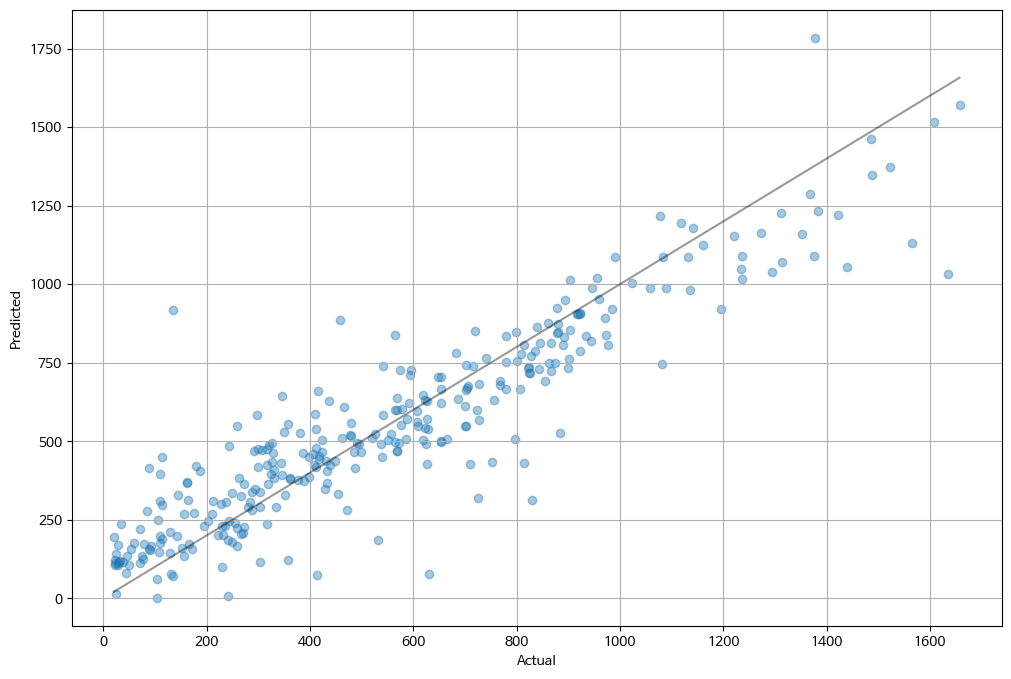

Lasso(alpha=1)
MAE: 104.98699617842107
R2: 0.8411907260984874


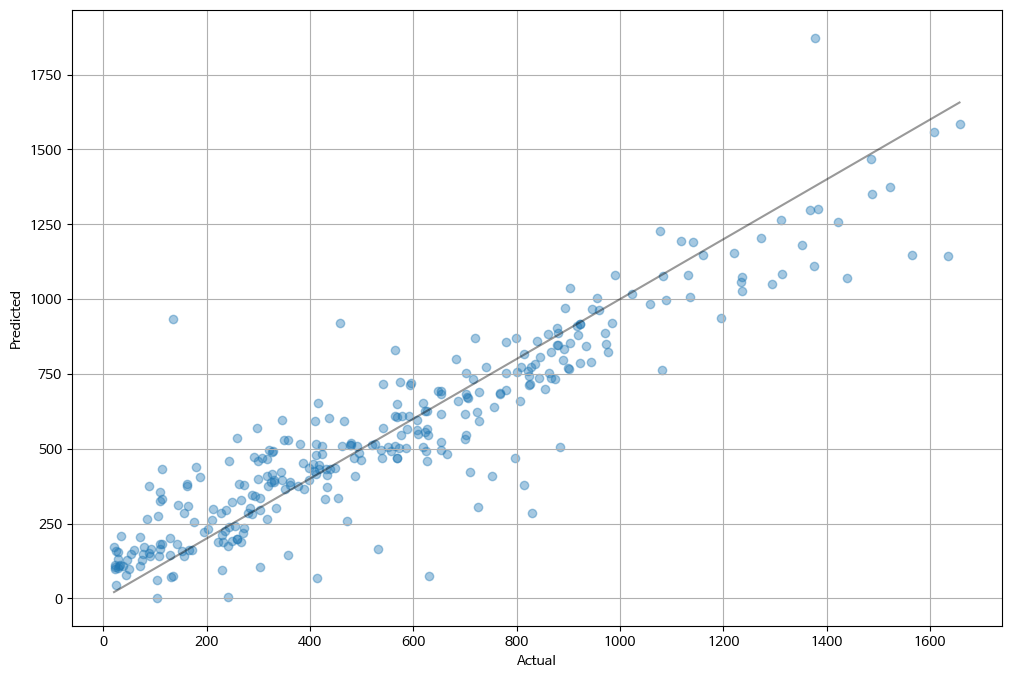

ElasticNet(alpha=0.01)
MAE: 109.09305144093621
R2: 0.8357515783678233


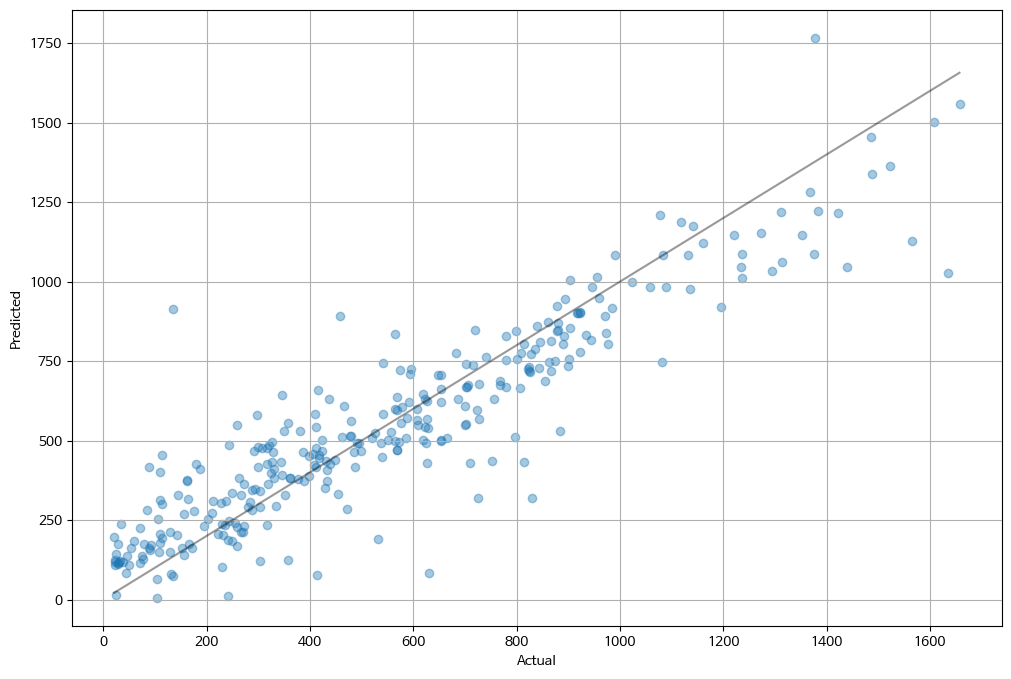

In [649]:
model_perf = pd.DataFrame(columns=['model', 'MAE', 'R2'])
for model in [best_ridge, best_lasso, best_elastic_net]:
  pred = model.predict(x)
  model_perf.loc[len(model_perf)] = [model, mean_absolute_error(y, pred), r2_score(y, pred)]
  print(model)
  print('MAE:', mean_absolute_error(y, pred))
  print('R2:', r2_score(y, pred))
  model_plot(y, pred)

In [650]:
# 라쏘 > 릿지 > 엘라스틱순으로 예측성이 높음.
model_perf

,model,MAE,R2
0,Ridge(alpha=1),108.291330,0.837117
1,Lasso(alpha=1),104.986996,0.841191
2,ElasticNet(alpha=0.01),109.093051,0.835752
